# Acoustic Anomaly Detection Notebook
#
This notebook trains and evaluates four different models on Mel-spectrogram frames:
1. **K-means Clustering** (unsupervised)
2. **Convolutional Autoencoder** (unsupervised, PyTorch)
3. **One-Class SVM** (unsupervised, scikit-learn)
4. **LSTM Autoencoder** (unsupervised, PyTorch)
#
The data is prepared using our usual logic:
- Generate Mel-spectrograms from anomalous and normal recordings.
- Slice them into overlapping frames.
- Split into train/validation/test sets.
#
For evaluation, we compute metrics such as ROC AUC, precision, recall, and F1,
plot confusion matrices and ROC curves, show reconstruction error distributions,
and (for autoencoders) visualize original vs. reconstructed frames.


## 1. Imports

In [8]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.cluster import KMeans
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, precision_recall_fscore_support,
                             confusion_matrix, roc_curve, ConfusionMatrixDisplay)
from sklearn.preprocessing import StandardScaler


## 2. Data Preparation: Mel-Spectrogram Frames

In [9]:
# Paths to audio files (update if necessary)
anomalous_audio_path = "../../Data/raw/13_real/Anomaly_knackgeräusche.wav"
normal_audio_path = "../../Data/raw/13_real/Normal_knackgeräusche.wav"

# Paths for saving frames and datasets
output_anomalous_frames_path = "../../Data/frames/anomalous_frames_real.npy"
output_normal_frames_path = "../../Data/frames/normal_frames_real.npy"
train_frames_path = "../../Data/datasets/train_frames_real.npy"
val_frames_path = "../../Data/datasets/val_frames_real.npy"
test_frames_path = "../../Data/datasets/test_frames_real.npy"
test_labels_path = "../../Data/datasets/test_labels_real.npy"

os.makedirs(os.path.dirname(output_anomalous_frames_path), exist_ok=True)
os.makedirs(os.path.dirname(train_frames_path), exist_ok=True)


def generate_mel_spectrogram(audio_path):
    """Generate a normalized Mel-spectrogram from an audio file."""
    audio, sr = librosa.load(audio_path, sr=None)
    stft = librosa.stft(audio, n_fft=1024, hop_length=512)
    mel = librosa.feature.melspectrogram(S=np.abs(stft) ** 2, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    mel_db_norm = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min())
    return mel_db_norm, sr


# Generate Mel-spectrograms
mel_db_anomalous, sr_anomalous = generate_mel_spectrogram(anomalous_audio_path)
mel_db_normal, sr_normal = generate_mel_spectrogram(normal_audio_path)
assert sr_anomalous == sr_normal, "Sampling rates do not match!"


def generate_frames(mel_spectrogram, frame_size, hop_size):
    """Generate overlapping frames from a Mel-spectrogram."""
    num_frames = (mel_spectrogram.shape[1] - frame_size) // hop_size + 1
    frames = np.zeros((num_frames, mel_spectrogram.shape[0], frame_size))
    for i in range(num_frames):
        start = i * hop_size
        frames[i] = mel_spectrogram[:, start:start + frame_size]
    return frames


# Adjustable parameters
time_per_frame = 0.6  # Duration of one frame in seconds
hop_ratio = 0.2  # Overlap ratio between frames
hop_length = 512
frame_size = int((time_per_frame * sr_anomalous) / hop_length)
hop_size = int(frame_size * hop_ratio)

# Generate frames
anomalous_frames = generate_frames(mel_db_anomalous, frame_size, hop_size)
normal_frames = generate_frames(mel_db_normal, frame_size, hop_size)

# Save frames
np.save(output_anomalous_frames_path, anomalous_frames)
np.save(output_normal_frames_path, normal_frames)


## 3. Train/Validation/Test Split

In [10]:
anomalous_frames = np.load(output_anomalous_frames_path)
normal_frames = np.load(output_normal_frames_path)

# Split normal frames into training, validation, and test sets
normal_train_val, normal_test = train_test_split(normal_frames, test_size=0.15, random_state=42)
normal_train, normal_val = train_test_split(normal_train_val, test_size=0.1765, random_state=42)

# Combine normal_test and anomalous_frames for testing
test_frames = np.concatenate([normal_test, anomalous_frames], axis=0)
test_labels = np.concatenate([np.zeros(len(normal_test)), np.ones(len(anomalous_frames))])

# Shuffle the test set
indices = np.arange(len(test_frames))
np.random.shuffle(indices)
test_frames = test_frames[indices]
test_labels = test_labels[indices]

# Save datasets
np.save(train_frames_path, normal_train)
np.save(val_frames_path, normal_val)
np.save(test_frames_path, test_frames)
np.save(test_labels_path, test_labels)

# Load for training
train_frames = np.load(train_frames_path)
val_frames = np.load(val_frames_path)
print("Train frames shape:", train_frames.shape)
print("Val frames shape:", val_frames.shape)
print("Test frames shape:", test_frames.shape)


Train frames shape: (21687, 128, 51)
Val frames shape: (4649, 128, 51)
Test frames shape: (4691, 128, 51)


## 4. Model 1: K-means Clustering (Unsupervised)
#
Normal frames are used to train K-means; the distance to the cluster center is used as an anomaly score.

=== K-means Results ===
Threshold (95th percentile): 109.9184
ROC AUC: 0.9683
Precision: 0.1294, Recall: 0.8605, F1: 0.2249
Confusion Matrix:
[[4399  249]
 [   6   37]]


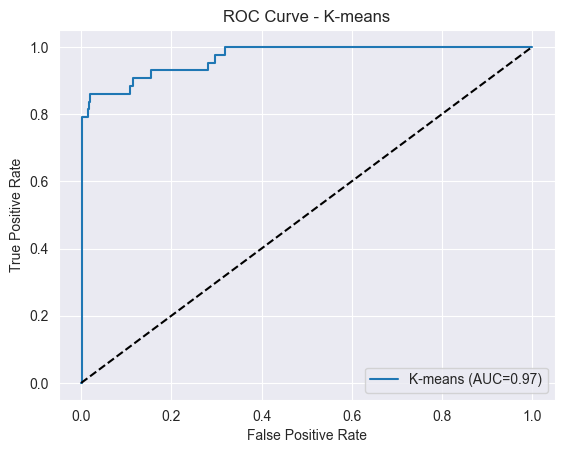

In [11]:
# Flatten frames for K-means
X_train_kmeans = train_frames.reshape(len(train_frames), -1)
X_val_kmeans = val_frames.reshape(len(val_frames), -1)
X_test_kmeans = test_frames.reshape(len(test_frames), -1)

scaler_kmeans = StandardScaler()
X_train_kmeans = scaler_kmeans.fit_transform(X_train_kmeans)
X_val_kmeans = scaler_kmeans.transform(X_val_kmeans)
X_test_kmeans = scaler_kmeans.transform(X_test_kmeans)

n_clusters = 1
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_train_kmeans)

dist_val = kmeans.transform(X_val_kmeans).min(axis=1)
dist_test = kmeans.transform(X_test_kmeans).min(axis=1)
threshold_kmeans = np.percentile(dist_val, 95)
y_pred_kmeans = (dist_test > threshold_kmeans).astype(int)

roc_auc_kmeans = roc_auc_score(test_labels, dist_test)
precision_kmeans, recall_kmeans, f1_kmeans, _ = precision_recall_fscore_support(test_labels, y_pred_kmeans,
                                                                                average='binary')
conf_kmeans = confusion_matrix(test_labels, y_pred_kmeans)

print("=== K-means Results ===")
print(f"Threshold (95th percentile): {threshold_kmeans:.4f}")
print(f"ROC AUC: {roc_auc_kmeans:.4f}")
print(f"Precision: {precision_kmeans:.4f}, Recall: {recall_kmeans:.4f}, F1: {f1_kmeans:.4f}")
print("Confusion Matrix:")
print(conf_kmeans)

fpr_k, tpr_k, _ = roc_curve(test_labels, dist_test)
plt.figure()
plt.plot(fpr_k, tpr_k, label=f'K-means (AUC={roc_auc_kmeans:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - K-means")
plt.legend()
plt.show()


## 5. Model 2: Convolutional Autoencoder (Unsupervised, PyTorch)
#
Frames are reshaped to (N, 1, 128, frame_size) for 2D convolution.

Conv AE train shape: torch.Size([21687, 1, 128, 51])
Epoch 1/10, Train Loss: 0.0548, Val Loss: 0.0287
Epoch 2/10, Train Loss: 0.0152, Val Loss: 0.0081
Epoch 3/10, Train Loss: 0.0060, Val Loss: 0.0047
Epoch 4/10, Train Loss: 0.0040, Val Loss: 0.0035
Epoch 5/10, Train Loss: 0.0032, Val Loss: 0.0029
Epoch 6/10, Train Loss: 0.0027, Val Loss: 0.0025
Epoch 7/10, Train Loss: 0.0023, Val Loss: 0.0022
Epoch 8/10, Train Loss: 0.0022, Val Loss: 0.0021
Epoch 9/10, Train Loss: 0.0021, Val Loss: 0.0020
Epoch 10/10, Train Loss: 0.0020, Val Loss: 0.0020


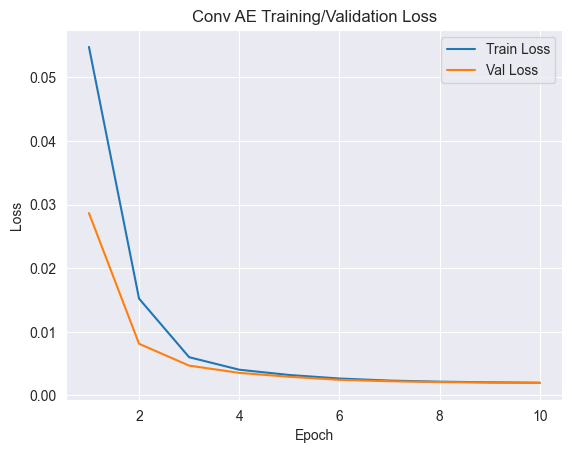

Conv AE threshold (95th percentile): 0.0021225417

=== Convolutional Autoencoder Results ===
ROC AUC: 0.8124
Precision: 0.0586, Recall: 0.3721, F1: 0.1013
Confusion Matrix:
[[4391  257]
 [  27   16]]


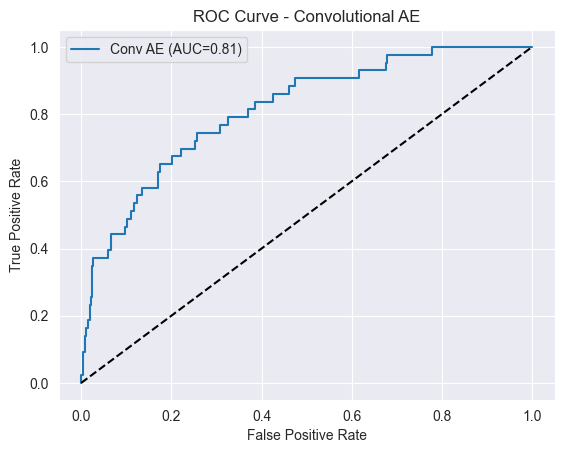

In [15]:
train_frames_tensor_ca = torch.tensor(train_frames, dtype=torch.float32).unsqueeze(1)
val_frames_tensor_ca = torch.tensor(val_frames, dtype=torch.float32).unsqueeze(1)
test_frames_tensor_ca = torch.tensor(test_frames, dtype=torch.float32).unsqueeze(1)
print("Conv AE train shape:", train_frames_tensor_ca.shape)

batch_size = 32
train_loader_ca = DataLoader(TensorDataset(train_frames_tensor_ca), batch_size=batch_size, shuffle=True)
val_loader_ca = DataLoader(TensorDataset(val_frames_tensor_ca), batch_size=batch_size)


class ConvAutoencoder(nn.Module):
    def __init__(self, input_shape=(1, 128, 51)):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), ceil_mode=True),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), ceil_mode=True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        # Crop output width from 52 to 51 if needed
        out = out[:, :, :, :51]
        return out


conv_ae = ConvAutoencoder(input_shape=(1, 128, 51))
conv_ae = conv_ae.float()

criterion_ca = nn.MSELoss()
optimizer_ca = optim.Adam(conv_ae.parameters(), lr=1e-4)

epochs_ca = 10
train_losses_ca = []
val_losses_ca = []

for epoch in range(epochs_ca):
    conv_ae.train()
    running_loss = 0.0
    for (inputs,) in train_loader_ca:
        optimizer_ca.zero_grad()
        outputs = conv_ae(inputs)
        loss = criterion_ca(outputs, inputs)
        loss.backward()
        optimizer_ca.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_train_loss = running_loss / len(train_loader_ca.dataset)
    train_losses_ca.append(epoch_train_loss)

    conv_ae.eval()
    val_loss = 0.0
    with torch.no_grad():
        for (inputs_val,) in val_loader_ca:
            outputs_val = conv_ae(inputs_val)
            loss_val = criterion_ca(outputs_val, inputs_val)
            val_loss += loss_val.item() * inputs_val.size(0)
    epoch_val_loss = val_loss / len(val_loader_ca.dataset)
    val_losses_ca.append(epoch_val_loss)

    print(f"Epoch {epoch + 1}/{epochs_ca}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

plt.figure()
plt.plot(range(1, epochs_ca + 1), train_losses_ca, label='Train Loss')
plt.plot(range(1, epochs_ca + 1), val_losses_ca, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Conv AE Training/Validation Loss')
plt.legend()
plt.show()

conv_ae.eval()
with torch.no_grad():
    val_outputs = conv_ae(val_frames_tensor_ca)
    val_mse = nn.functional.mse_loss(val_outputs, val_frames_tensor_ca, reduction='none')
    val_mse = val_mse.view(val_mse.size(0), -1).mean(dim=1).numpy()

threshold_ca = np.percentile(val_mse, 95)
print("Conv AE threshold (95th percentile):", threshold_ca)

with torch.no_grad():
    test_outputs = conv_ae(test_frames_tensor_ca)
    test_mse = nn.functional.mse_loss(test_outputs, test_frames_tensor_ca, reduction='none')
    test_mse = test_mse.view(test_mse.size(0), -1).mean(dim=1).numpy()

y_pred_ca = (test_mse > threshold_ca).astype(int)

roc_auc_ca = roc_auc_score(test_labels, test_mse)
precision_ca, recall_ca, f1_ca, _ = precision_recall_fscore_support(test_labels, y_pred_ca, average='binary')
conf_ca = confusion_matrix(test_labels, y_pred_ca)

print("\n=== Convolutional Autoencoder Results ===")
print(f"ROC AUC: {roc_auc_ca:.4f}")
print(f"Precision: {precision_ca:.4f}, Recall: {recall_ca:.4f}, F1: {f1_ca:.4f}")
print("Confusion Matrix:")
print(conf_ca)

fpr_ca, tpr_ca, _ = roc_curve(test_labels, test_mse)
plt.figure()
plt.plot(fpr_ca, tpr_ca, label=f'Conv AE (AUC={roc_auc_ca:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Convolutional AE")
plt.legend()
plt.show()


## 6. Model 3: One-Class SVM (Unsupervised, scikit-learn)
#
One-Class SVM is trained on normal data only. We then compute the decision function on the test set.


=== One-Class SVM Results ===
ROC AUC: 0.9963
Precision: 0.1463, Recall: 1.0000, F1: 0.2552
Confusion Matrix:
[[4397  251]
 [   0   43]]


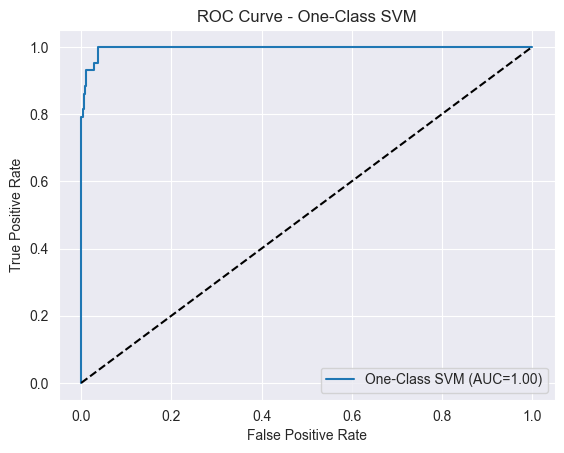

In [13]:
# Flatten frames for One-Class SVM
X_train_ocsvm = normal_train.reshape(len(normal_train), -1)
X_test_ocsvm = test_frames.reshape(len(test_frames), -1)

scaler_ocsvm = StandardScaler()
X_train_ocsvm = scaler_ocsvm.fit_transform(X_train_ocsvm)
X_test_ocsvm = scaler_ocsvm.transform(X_test_ocsvm)

# Train One-Class SVM on normal data
ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)
ocsvm.fit(X_train_ocsvm)

# Decision function (the lower, the more abnormal)
decision_scores = ocsvm.decision_function(X_test_ocsvm)
# Convert decision scores to anomaly predictions: negative values are anomalies.
y_pred_ocsvm = (decision_scores < 0).astype(int)

roc_auc_ocsvm = roc_auc_score(test_labels, -decision_scores)
precision_ocsvm, recall_ocsvm, f1_ocsvm, _ = precision_recall_fscore_support(test_labels, y_pred_ocsvm,
                                                                             average='binary')
conf_ocsvm = confusion_matrix(test_labels, y_pred_ocsvm)

print("\n=== One-Class SVM Results ===")
print(f"ROC AUC: {roc_auc_ocsvm:.4f}")
print(f"Precision: {precision_ocsvm:.4f}, Recall: {recall_ocsvm:.4f}, F1: {f1_ocsvm:.4f}")
print("Confusion Matrix:")
print(conf_ocsvm)

fpr_oc, tpr_oc, _ = roc_curve(test_labels, -decision_scores)
plt.figure()
plt.plot(fpr_oc, tpr_oc, label=f'One-Class SVM (AUC={roc_auc_ocsvm:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - One-Class SVM")
plt.legend()
plt.show()



## 7. Model 4: LSTM Autoencoder (Unsupervised, PyTorch)
#
For the LSTM autoencoder, we treat each frame as a sequence.
We reshape each frame from (128, frame_size) to (frame_size, 128), i.e., time steps = frame_size, features = 128.

LSTM AE train shape: torch.Size([21687, 51, 128])
Epoch 1/10, Train Loss: 0.0289, Val Loss: 0.0031
Epoch 2/10, Train Loss: 0.0026, Val Loss: 0.0024
Epoch 3/10, Train Loss: 0.0024, Val Loss: 0.0023
Epoch 4/10, Train Loss: 0.0023, Val Loss: 0.0022
Epoch 5/10, Train Loss: 0.0022, Val Loss: 0.0022
Epoch 6/10, Train Loss: 0.0022, Val Loss: 0.0021
Epoch 7/10, Train Loss: 0.0021, Val Loss: 0.0021
Epoch 8/10, Train Loss: 0.0021, Val Loss: 0.0021
Epoch 9/10, Train Loss: 0.0021, Val Loss: 0.0021
Epoch 10/10, Train Loss: 0.0021, Val Loss: 0.0021


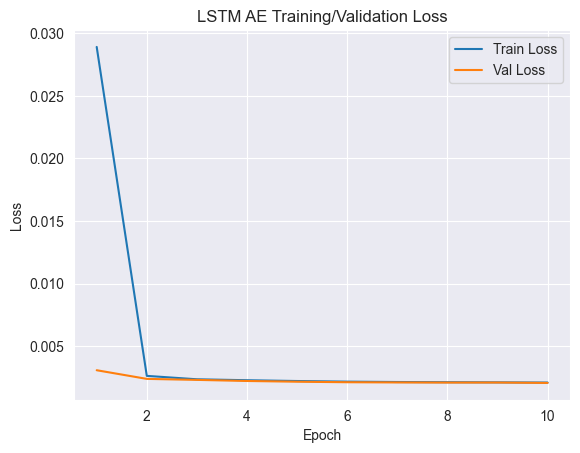

LSTM AE threshold (95th percentile): 0.0022464672

=== LSTM Autoencoder Results ===
ROC AUC: 0.9943
Precision: 0.1438, Recall: 1.0000, F1: 0.2515
Precision: 0.1438, Recall: 1.0000, F1: 0.2515
Confusion Matrix:
[[4392  256]
 [   0   43]]


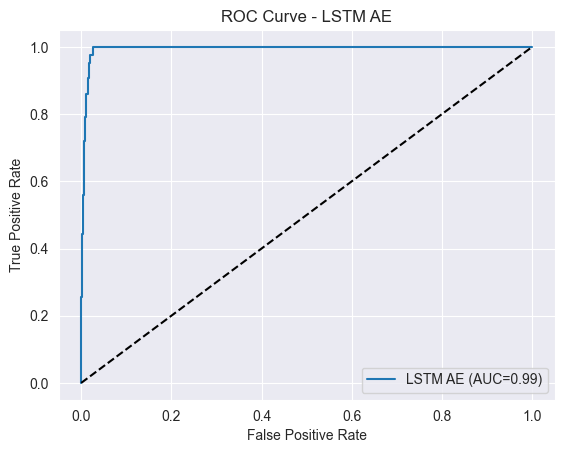

In [18]:
# Prepare data for LSTM AE:
def reshape_for_lstm(frames):
    # frames: (N, 128, frame_size) -> (N, frame_size, 128)
    return np.transpose(frames, (0, 2, 1))


train_frames_lstm = reshape_for_lstm(normal_train)  # use only normal frames for training
val_frames_lstm = reshape_for_lstm(normal_val)
test_frames_lstm = reshape_for_lstm(test_frames)

# Convert to PyTorch tensors
train_frames_tensor_lstm = torch.tensor(train_frames_lstm, dtype=torch.float32)
val_frames_tensor_lstm = torch.tensor(val_frames_lstm, dtype=torch.float32)
test_frames_tensor_lstm = torch.tensor(test_frames_lstm, dtype=torch.float32)

print("LSTM AE train shape:", train_frames_tensor_lstm.shape)  # (N, time_steps, features)

# Create DataLoaders
batch_size_lstm = 32
train_loader_lstm = DataLoader(TensorDataset(train_frames_tensor_lstm), batch_size=batch_size_lstm, shuffle=True)
val_loader_lstm = DataLoader(TensorDataset(val_frames_tensor_lstm), batch_size=batch_size_lstm)


# Define LSTM Autoencoder
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size=128, hidden_size=64, latent_size=32, num_layers=1):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc_enc = nn.Linear(hidden_size, latent_size)

        self.fc_dec = nn.Linear(latent_size, hidden_size)
        self.decoder = nn.LSTM(hidden_size, input_size, num_layers, batch_first=True)

    def forward(self, x):
        # x: (batch, time_steps, features)
        enc_out, _ = self.encoder(x)  # enc_out: (batch, time_steps, hidden_size)
        # Take the last time step
        last_hidden = enc_out[:, -1, :]  # (batch, hidden_size)
        latent = self.fc_enc(last_hidden)  # (batch, latent_size)

        # Decode: expand latent to sequence length
        dec_input = self.fc_dec(latent).unsqueeze(1)  # (batch, 1, hidden_size)
        # Repeat for time_steps times:
        dec_input = dec_input.repeat(1, x.size(1), 1)  # (batch, time_steps, hidden_size)
        dec_out, _ = self.decoder(dec_input)  # (batch, time_steps, input_size)
        return dec_out


lstm_ae = LSTMAutoencoder(input_size=128, hidden_size=64, latent_size=32, num_layers=1)
lstm_ae = lstm_ae.float()

criterion_lstm = nn.MSELoss()
optimizer_lstm = optim.Adam(lstm_ae.parameters(), lr=1e-4)

epochs_lstm = 10
train_losses_lstm = []
val_losses_lstm = []

for epoch in range(epochs_lstm):
    lstm_ae.train()
    running_loss = 0.0
    for (inputs,) in train_loader_lstm:
        optimizer_lstm.zero_grad()
        outputs = lstm_ae(inputs)
        loss = criterion_lstm(outputs, inputs)
        loss.backward()
        optimizer_lstm.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_train_loss = running_loss / len(train_loader_lstm.dataset)
    train_losses_lstm.append(epoch_train_loss)

    lstm_ae.eval()
    val_loss = 0.0
    with torch.no_grad():
        for (inputs_val,) in val_loader_lstm:
            outputs_val = lstm_ae(inputs_val)
            loss_val = criterion_lstm(outputs_val, inputs_val)
            val_loss += loss_val.item() * inputs_val.size(0)
    epoch_val_loss = val_loss / len(val_loader_lstm.dataset)
    val_losses_lstm.append(epoch_val_loss)

    print(f"Epoch {epoch + 1}/{epochs_lstm}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

plt.figure()
plt.plot(range(1, epochs_lstm + 1), train_losses_lstm, label='Train Loss')
plt.plot(range(1, epochs_lstm + 1), val_losses_lstm, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM AE Training/Validation Loss')
plt.legend()
plt.show()

# Determine threshold on validation set for LSTM AE
lstm_ae.eval()
with torch.no_grad():
    val_outputs = lstm_ae(val_frames_tensor_lstm)
    val_mse = nn.functional.mse_loss(val_outputs, val_frames_tensor_lstm, reduction='none')
    val_mse = val_mse.reshape(val_mse.size(0), -1).mean(dim=1).numpy()

threshold_lstm = np.percentile(val_mse, 95)
print("LSTM AE threshold (95th percentile):", threshold_lstm)

with torch.no_grad():
    test_outputs = lstm_ae(test_frames_tensor_lstm)
    test_mse = nn.functional.mse_loss(test_outputs, test_frames_tensor_lstm, reduction='none')
    test_mse = test_mse.reshape(test_mse.size(0), -1).mean(dim=1).numpy()

y_pred_lstm = (test_mse > threshold_lstm).astype(int)

roc_auc_lstm = roc_auc_score(test_labels, test_mse)
precision_lstm, recall_lstm, f1_lstm, _ = precision_recall_fscore_support(test_labels, y_pred_lstm, average='binary')
conf_lstm = confusion_matrix(test_labels, y_pred_lstm)

print("\n=== LSTM Autoencoder Results ===")
print(f"ROC AUC: {roc_auc_lstm:.4f}")
print(f"Precision: {precision_lstm:.4f}, Recall: {recall_lstm:.4f}, F1: {f1_lstm:.4f}")
print(f"Precision: {precision_lstm:.4f}, Recall: {recall_lstm:.4f}, F1: {f1_lstm:.4f}")
print("Confusion Matrix:")
print(conf_lstm)

fpr_lstm, tpr_lstm, _ = roc_curve(test_labels, test_mse)
plt.figure()
plt.plot(fpr_lstm, tpr_lstm, label=f'LSTM AE (AUC={roc_auc_lstm:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LSTM AE")
plt.legend()
plt.show()



## 8. Additional Evaluation: Visualization & Error Distribution
#
We'll now identify indices for correctly classified anomalies,
wrongly classified anomalies, and wrongly classified normals, and visualize them.
We'll also plot the reconstruction error distribution for autoencoders.

Correctly Classified Anomalies (Conv AE):


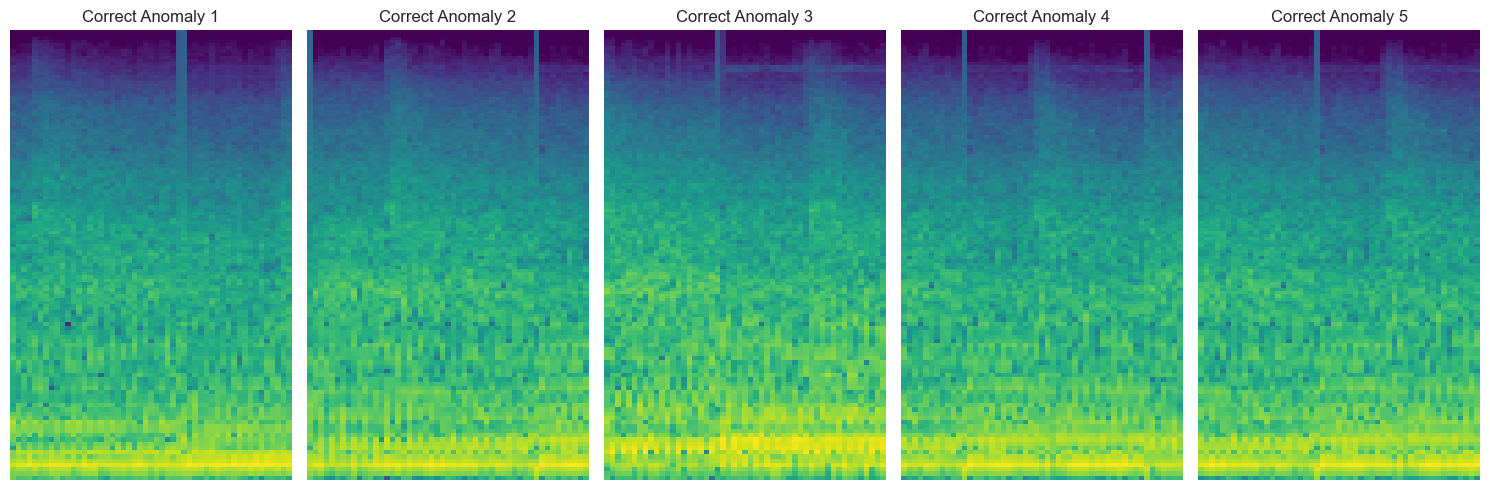

Wrongly Classified Anomalies (Conv AE):


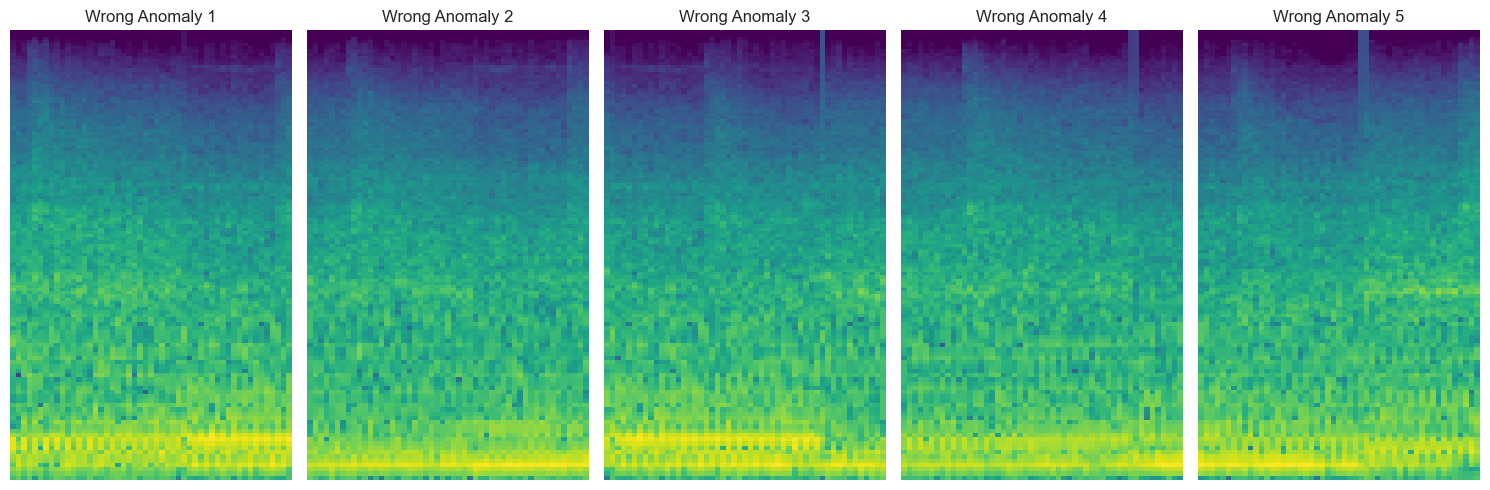

Wrongly Classified Normal Frames (Conv AE):


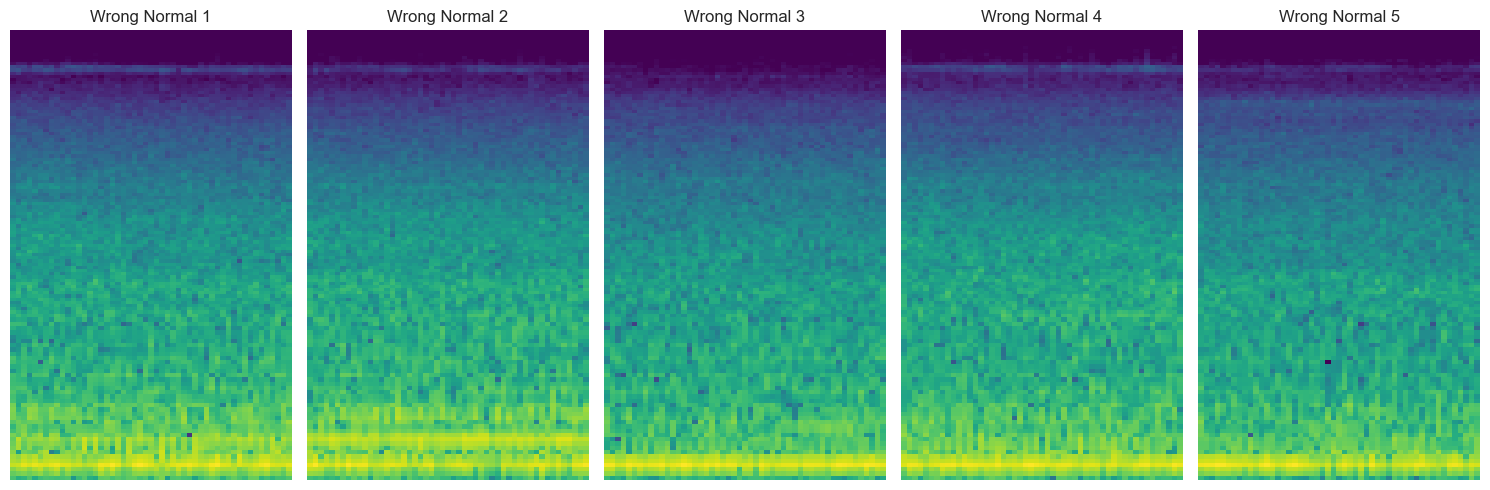

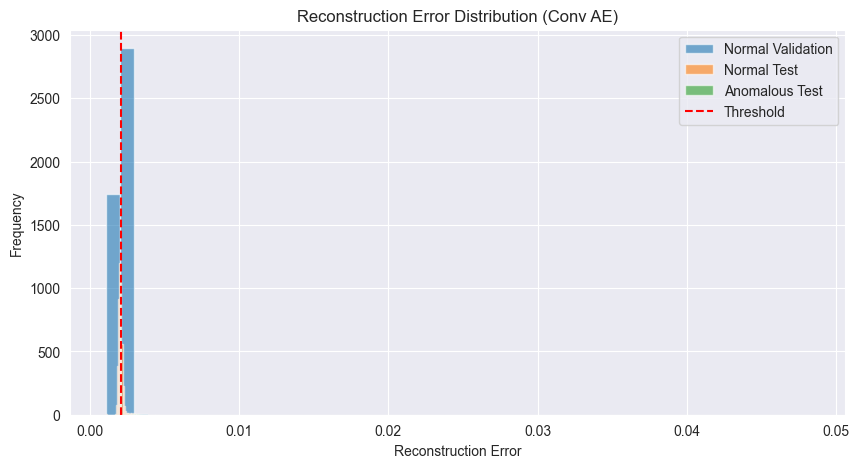

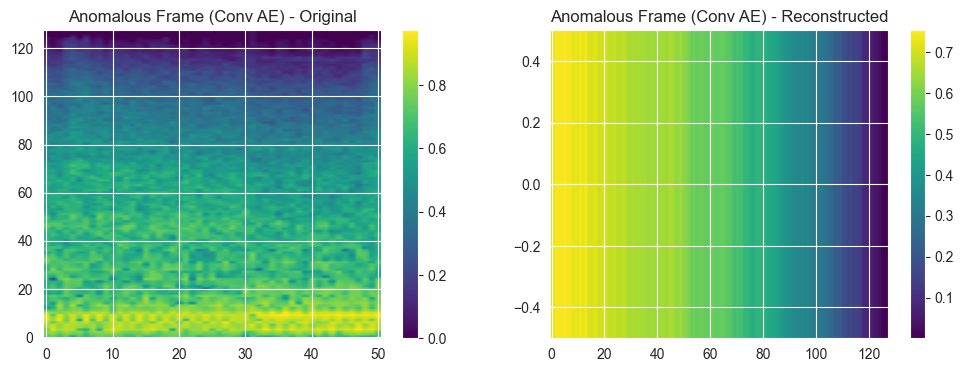

In [20]:
def plot_specified_frames(frames, indices, title_prefix="Frame"):
    num_frames = len(indices)
    if num_frames == 0:
        print(f"No frames to plot for {title_prefix}.")
        return
    fig, axes = plt.subplots(1, num_frames, figsize=(15, 5))
    if num_frames == 1:
        axes = [axes]
    for i, idx in enumerate(indices):
        ax = axes[i]
        img = librosa.display.specshow(frames[idx], x_axis=None, y_axis="mel", cmap="viridis", ax=ax)
        ax.set_title(f"{title_prefix} {i + 1}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()


# For autoencoder models, use predictions from test set:
# We'll demonstrate with Conv AE predictions as an example.
# Identify indices:
correctly_classified_anomalies = np.where((test_labels == 1) & (y_pred_ca == 1))[0]
wrongly_classified_anomalies = np.where((test_labels == 1) & (y_pred_ca == 0))[0]
wrongly_classified_normals = np.where((test_labels == 0) & (y_pred_ca == 1))[0]

num_samples = 5
correct_anomaly_indices = correctly_classified_anomalies[:num_samples]
wrong_anomaly_indices = wrongly_classified_anomalies[:num_samples]
wrong_normal_indices = wrongly_classified_normals[:num_samples]

print("Correctly Classified Anomalies (Conv AE):")
plot_specified_frames(test_frames, correct_anomaly_indices, title_prefix="Correct Anomaly")
print("Wrongly Classified Anomalies (Conv AE):")
plot_specified_frames(test_frames, wrong_anomaly_indices, title_prefix="Wrong Anomaly")
print("Wrongly Classified Normal Frames (Conv AE):")
plot_specified_frames(test_frames, wrong_normal_indices, title_prefix="Wrong Normal")

# Plot reconstruction error distribution for Conv AE:
test_losses_normal = test_mse[test_labels == 0]
test_losses_anomalous = test_mse[test_labels == 1]

plt.figure(figsize=(10, 5))
plt.hist(val_mse, bins=50, alpha=0.6, label='Normal Validation')
plt.hist(test_losses_normal, bins=50, alpha=0.6, label='Normal Test')
plt.hist(test_losses_anomalous, bins=50, alpha=0.6, label='Anomalous Test')
plt.axvline(x=threshold_ca, color='red', linestyle='--', label='Threshold')
plt.title("Reconstruction Error Distribution (Conv AE)")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()


# For LSTM AE, you can similarly compute reconstruction errors,
# identify indices, and plot original vs. reconstructed frames.
def plot_original_vs_reconstructed(original, reconstructed, title):
    # Ensure both arrays are at least 2D
    original = np.atleast_2d(original)
    reconstructed = np.atleast_2d(reconstructed)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original, aspect='auto', origin='lower', cmap='viridis')
    plt.title(f"{title} - Original")
    plt.colorbar()
    
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed, aspect='auto', origin='lower', cmap='viridis')
    plt.title(f"{title} - Reconstructed")
    plt.colorbar()
    plt.show()



# Visualize one anomalous frame for Conv AE (example):
anomalous_indices = np.where(test_labels == 1)[0]
if len(anomalous_indices) > 0:
    idx = anomalous_indices[0]
    original_frame = test_frames[idx]
    # For Conv AE, get the reconstructed frame from torch tensor:
    reconstructed_frame = test_outputs[idx].detach().cpu().numpy()[0]  # shape (128,51)
    plot_original_vs_reconstructed(original_frame, reconstructed_frame, "Anomalous Frame (Conv AE)")
else:
    print("No anomalous frames to visualize.")


## 9. Conclusion
#
We trained and evaluated four models on Mel-spectrogram frames:
1. **K-means Clustering**
2. **Convolutional Autoencoder**
3. **One-Class SVM**
4. **LSTM Autoencoder**
#
Each model used the same data-preparation pipeline and was evaluated using ROC AUC, confusion matrices,
and for the autoencoders, reconstruction error distributions and visualizations of reconstructed frames.
